<a href="https://colab.research.google.com/github/ByeolHan/Mediapipe_project/blob/main/Mediapipe_project_20173374%ED%95%9C%EB%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **손카; 손과 차의 커뮤니케이션**
: 커넥티드 카의 음성인식 기술의 단점을 보완할 수 있는 손동작 인식 기술
## 예상성과
* 농아인들의 편리한 운전 감성 경험을 도울 수 있다. 
* 지역 방언에 상관없이 기술을 사용할 수 있다.
* 제스처를 지정한다면, 언어에 국한되지 않고 사용될 수 있다. 
 * 자율주행이 구현된 상황, 공유 모빌리티에서 유용하게 사용될 수 있다.)  
* 기타 활동으로 인한 영상, 음성 등의 소음에 영향을 받지 않고 차량을 제어할 수 있다. 

# **Overview**
- Mediapipe의 Pose classifcation(basic)을 이용 
- hand gesture 이미지들의 landmark 정보들을 csv 파일로 받은 후 
- sklearn 머신러닝 모델들을 이용하여 학습
- 가장 정확도가 높은 RandomForestClassifier 모델을 이용하여 pose 사진과 동영상에 클래스& 확률 나타내기

# **0. 환경 구현**

In [ ]:
!pip install numpy==1.19.3
!pip install opencv-python==4.5.1.48
!pip install tqdm==4.56.0

!pip install mediapipe==0.8.3

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# **1. 이미지 샘플 불러오기**

In [ ]:
import os
path = "/content/gdrive/MyDrive/Colab Notebooks/assignment4"
os.chdir(path)

In [ ]:
# 이미지 폴더
images_in_folder = 'hand_gesture_images_in'

# 이미지 출력 폴더
images_out_folder = 'hand_gesture_images__out_basic'

# csv출력 주소
csv_out_path = 'hand_gesture_csvs_out_basic.csv'

# **2. mediapipe 모델에 이미지 삽입**

In [ ]:
import csv
import cv2
import numpy as np
import os
import sys
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


with open(csv_out_path, 'w') as csv_out_file:
  csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

  # 폴더 이름으로 class_name 설정
  pose_class_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])

  for pose_class_name in pose_class_names:
    print('Bootstrapping ', pose_class_name, file=sys.stderr)

    if not os.path.exists(os.path.join(images_out_folder, pose_class_name)):
      os.makedirs(os.path.join(images_out_folder, pose_class_name))

    image_names = sorted([
        n for n in os.listdir(os.path.join(images_in_folder, pose_class_name))
        if not n.startswith('.')])
    for image_name in tqdm.tqdm(image_names, position=0):
      # 이미지 다시 불러오기
      input_frame = cv2.imread(os.path.join(images_in_folder, pose_class_name, image_name))
      input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

      # pose_tracker 초기화
      with mp_pose.Pose(upper_body_only=False) as pose_tracker:
        result = pose_tracker.process(image=input_frame)
        pose_landmarks = result.pose_landmarks
      
      # pose detection.
      output_frame = input_frame.copy()
      if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS)
      output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
      cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
      
      # Save landmarks.
      if pose_landmarks is not None:

        # landmark개수가 33개인지 점검
        assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
        pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

        frame_height, frame_width = output_frame.shape[:2]
        pose_landmarks *= np.array([frame_width, frame_height, frame_width])

        # CSV파일로 출력
        pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.str).tolist()
        csv_out_writer.writerow([pose_class_name] + pose_landmarks)


Bootstrapping  emergency
100%|██████████| 40/40 [00:18<00:00,  2.19it/s]
Bootstrapping  play
100%|██████████| 31/31 [00:15<00:00,  2.00it/s]
Bootstrapping  stop
100%|██████████| 41/41 [00:21<00:00,  1.93it/s]


# **3. 모델 훈련**

## **3.1 데이터 불러오기**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# 헤더행 설정
head = ["class"] 
for i in range(1,34):
    head.append("x"+str(i))
    head.append("y"+str(i))
    head.append("z"+str(i))
print(head)

In [ ]:
df = pd.read_csv('hand_gesture_csvs_out_basic.csv',names = head)

In [ ]:
df.shape[0]

80

In [ ]:
df.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,...,z20,x21,y21,z21,x22,y22,z22,x23,y23,z23,x24,y24,z24,x25,y25,z25,x26,y26,z26,x27,y27,z27,x28,y28,z28,x29,y29,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32,x33,y33,z33
0,emergency,627.02980,680.44167,-546.36513,635.79765,710.90487,-575.54054,637.69951,716.81459,-575.27527,639.37672,722.85393,-575.33428,631.38725,694.10889,-579.92290,629.94331,687.63205,-579.76204,628.27446,681.06176,-579.71306,642.89520,711.79871,-526.62071,621.02875,656.15553,-544.35719,620.32127,661.37827,-509.03496,617.52289,642.57013,-513.24017,702.91534,571.95505,-274.27551,553.65547,511.27550,-366.07101,...,92.44203,584.92241,625.99485,94.28527,625.66963,604.38183,113.77059,594.87976,607.11336,98.92643,692.50710,139.25501,60.31883,593.84071,110.00319,-59.01154,728.35953,283.31243,302.23627,504.04480,224.73789,108.97112,730.52277,421.76508,349.17557,634.95155,415.38317,214.86336,735.39162,425.86736,350.72605,662.79778,439.91352,229.13261,733.68729,538.69663,362.34097,656.09886,518.41993,359.27994
1,emergency,605.42530,574.33622,-450.65788,587.16469,618.42356,-486.84959,579.56535,621.54316,-486.58096,571.78261,624.93359,-486.65695,613.06587,617.27337,-502.99011,623.73207,621.35742,-503.05653,634.13044,625.17855,-503.26740,575.08961,655.26793,-447.36195,663.24104,656.61604,-523.81348,606.48083,564.73989,-410.92125,635.17384,568.21661,-433.20889,570.60181,611.26797,-302.31899,774.69528,529.01281,-373.40710,...,-498.03497,724.97185,529.40374,-451.11362,473.17146,605.14452,-477.37816,732.83615,515.05451,-454.46587,598.74615,139.62693,34.69418,691.34338,108.18728,-34.19399,504.51962,360.47934,203.77327,667.78084,266.17616,93.95242,618.67363,517.50040,244.59536,779.62852,488.29777,303.22460,635.24170,549.19058,246.94023,798.85941,529.48414,317.45487,670.15686,564.78218,184.68317,819.93149,549.34204,309.40922
2,emergency,828.03856,544.68258,-258.04676,829.84726,576.31599,-311.04532,822.74506,579.89216,-310.95554,815.51849,583.53991,-311.11948,841.12488,574.00761,-266.65195,843.61267,575.53499,-266.56769,845.69756,576.73296,-267.04533,779.56009,593.25806,-411.16528,820.81886,583.83276,-204.34395,791.89011,530.16918,-281.23423,805.21790,526.18521,-219.95493,678.28079,517.42058,-402.94289,690.91919,519.67798,-77.72584,...,-222.32445,890.86433,566.20531,-248.85078,875.36674,561.06972,-162.95298,883.61465,556.21010,-221.11591,570.30144,141.92405,-109.31010,567.29931,160.06097,110.48246,796.86577,366.29797,-50.15348,758.93593,416.30613,205.33855,863.32253,466.82013,185.32335,826.75789,479.55565,264.82935,858.59886,466.04327,209.15220,820.88608,472.96051,267.26309,931.74278,551.80109,192.23700,901.54854,549.23298,256.00094
3,emergency,553.63483,673.93444,-542.48077,530.74181,725.04038,-543.63007,514.84444,725.49408,-543.91808,498.71243,725.96317,-544.39430,573.25401,726.86256,-552.23896,589.48841,729.19390,-552.99782,605.79399,731.43436,-553.76759,478.86726,723.78656,-378.77804,626.10374,731.73025,-415.64159,526.97426,637.11576,-465.83439,580.81444,640.37441,-475.86281,385.05981,526.50215,-195.21156,757.04025,565.85032,-220.56564,...,-509.82254,666.39221,589.73179,-737.19307,416.42670,628.66848,-489.89452,666.45889,563.87655,-721.47903,534.68994,50.93635,20.78762,742.20871,73.13312,-19.77090,556.54640,-264.63793,101.39510,736.09756,-278.95197,69.47707,610.01049,-565.59528,476.33667,742.20573,-573.36576,429.14219,620.70515,-605.62208,506.62369,752.98912,-610.04843,454.57191,633.02574,-678.38842,289.64584,708.95485,-690.02569,228.08115
4,emergency,556.65672,608.12988,-243.71372,547.58492,644.13626,-292.91882,544.34151,645.46417,-293.00257,540.98846,646.78951,-293.23544,550.47314,642.07472,-286.66473,551.08498,642.17651,-286.70506,551.46118,641.94649,-286.98940,531.79039,639.25524,-347.43477,538.90095,630.53965,-322.48989,547.17396,581.41382,-245.04261,554.90593,580.02039,-238.14579,564.42352,488.74123,-199.75193,496.71497,477.66091,-262.92719

In [ ]:
X = df.drop('class', axis=1)
y = df['class']

In [ ]:
# 트레이닝셋, 테스트셋 7:3 배분
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

## **3.2 모델 학습**

In [ ]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'sv': make_pipeline(StandardScaler(), SVC()),
    'kn': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=4)),
}

In [ ]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [ ]:
fit_models

## **3.3 모델 평가**

In [ ]:
from sklearn.metrics import accuracy_score # Accuracy metrics 
import pickle

In [ ]:
for name, model in fit_models.items():
    yhat = model.predict(X_test)
    print(name, accuracy_score(y_test, yhat))

lr 0.9166666666666666
rc 0.875
rf 0.9583333333333334
gb 0.875
sv 0.9166666666666666
kn 0.9166666666666666


In [ ]:
# RidgeClassifier 모델의 예측값
fit_models['rf'].predict(X_test)

array(['play', 'emergency', 'emergency', 'stop', 'emergency', 'stop',
       'play', 'play', 'emergency', 'stop', 'stop', 'emergency', 'stop',
       'emergency', 'emergency', 'stop', 'stop', 'play', 'stop', 'stop',
       'stop', 'stop', 'emergency', 'play'], dtype=object)

In [ ]:
# 실제 class
y_test

46         play
21    emergency
10    emergency
54         stop
29    emergency
67         stop
75         stop
45         play
18    emergency
68         stop
64         stop
4     emergency
77         stop
22    emergency
27    emergency
62         stop
73         stop
42         play
56         stop
74         stop
63         stop
66         stop
6     emergency
35         play
Name: class, dtype: object

In [ ]:
# 가장 성능이 좋은 모델 사용
with open('hand_gesture.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

# **4. 모델에 동영상을 대입하여 test**

## **4.1 test사진 출력**

In [ ]:
with open('hand_gesture.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 3.JPG to 3.JPG


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
for name in uploaded.keys():
    input_frame = cv2.imread(name)
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

play 0.71


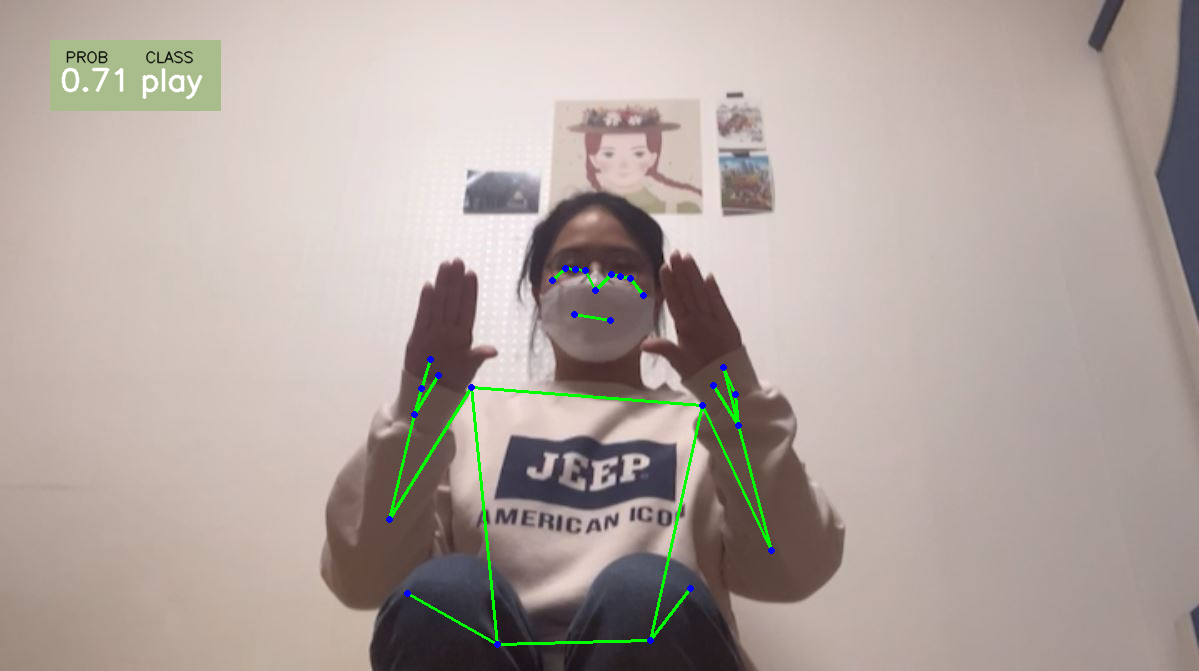

In [ ]:
# pose_tracker 초기화
with mp_pose.Pose(upper_body_only=False) as pose_tracker:
    result = pose_tracker.process(image=input_frame)
    pose_landmarks = result.pose_landmarks

output_frame = input_frame.copy()
if pose_landmarks is not None:
    mp_drawing.draw_landmarks(
    image=output_frame,
    landmark_list=pose_landmarks,
    connections=mp_pose.POSE_CONNECTIONS,)
output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)

if pose_landmarks is not None:

    assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
    pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

frame_height, frame_width = output_frame.shape[:2]
pose_landmarks *= np.array([frame_width, frame_height, frame_width])


pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.str).tolist()

X = pd.DataFrame(pose_landmarks)
X = X.transpose()
hand_gesture_class = model.predict(X)[0]
hand_gesture_prob = model.predict_proba(X)[0]
hand_gesture_prob =hand_gesture_prob[np.argmax(hand_gesture_prob)]

print(hand_gesture_class,hand_gesture_prob)

coords = tuple(np.multiply(np.array((result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].x, 
                                    result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].y)), [640,480]).astype(int))

cv2.rectangle(output_frame,(50,40), (220, 110), (139,188,169), -1)
# Class 출력
cv2.putText(output_frame, 'CLASS', (145,62), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
cv2.putText(output_frame, hand_gesture_class.split(' ')[0], (140,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

# 가능성 출력
cv2.putText(output_frame, 'PROB', (65,62), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
cv2.putText(output_frame, str(hand_gesture_prob), (60,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

cv2_imshow(output_frame)

## **4.2 test비디오 출력**

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving test12.mp4 to test12.mp4


In [ ]:
for name in uploaded.keys():
    video_path = name

In [ ]:
cap  = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS)) 
length = int((cap.get(cv2.CAP_PROP_FRAME_COUNT))/fps)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

count = 
idx = 1 # 이미지 번호 순차적으로 표현
success = True # 프레임이 제대로 읽혔는지 확인

fourcc = cv2.VideoWriter_fourcc(*'DIVX') # 저장할 비디오 코덱
out = cv2.VideoWriter("test_12_result.mp4",fourcc,fps,(int(width),int(height)))

for count in range(fps * length) :
    success, input_frame = cap.read()
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    if count % 1 == 0: 

        with mp_pose.Pose(upper_body_only=False) as pose_tracker:
            result = pose_tracker.process(image=input_frame)
            pose_landmarks = result.pose_landmarks

        output_frame = input_frame.copy()
        if pose_landmarks is not None:
            mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS,)
            output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)

        if pose_landmarks is not None:

        # landmark개수가 33개인지 점검
            assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
            pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

        height, width = output_frame.shape[:2]
        pose_landmarks *= np.array([width, height, width])


        pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.str).tolist()

        X = pd.DataFrame(pose_landmarks)
        X = X.transpose()
        hand_gesture_class = model.predict(X)[0]
        hand_gesture_prob = model.predict_proba(X)[0]
        hand_gesture_prob =hand_gesture_prob[np.argmax(hand_gesture_prob)]

        print(hand_gesture_class,hand_gesture_prob)

        coords = tuple(np.multiply(np.array((result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].x, 
                                            result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].y)), [640,480]).astype(int))

        cv2.rectangle(output_frame,(50,40), (220, 110), (139,188,169), -1)
        # Class 출력
        cv2.putText(output_frame, 'CLASS', (145,62), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(output_frame, hand_gesture_class.split(' ')[0], (140,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # 가능성 출력
        cv2.putText(output_frame, 'PROB', (65,62), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(output_frame, str(hand_gesture_prob), (60,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2_imshow(output_frame)
        out.write(output_frame)
        print("save output_frame %d/%d to video" %(idx, fps * length))
        idx += 1

    if cv2.waitKey(10) == 27: #esc 누르면 break
        break
    count += 1

else:
    cap.release()

out.release()    
pass